# **HW3-P1: Energy-Based Models**

In this assignment, we study **Energy-Based Models (EBMs)** as generative models and practice implementing them in PyTorch. We will connect the abstract definition of an EBM to concrete code for energy networks, Langevin sampling, contrastive divergence training, and NCE-style objectives.


## Part 1: **Neural Energy Functions & Langevin Dynamics**

In **Part 1**, we define a simple **neural energy function** $E_\theta(x)$ over low-dimensional data (e.g., the 2D moons dataset). We use this network to assign low energy to regions where real data live and high energy elsewhere. We then implement **Langevin dynamics** as a gradient-based MCMC sampler that approximately draws samples from the model distribution by iteratively following $-\nabla_x E_\theta(x)$ plus Gaussian noise.

You are given 2D data $x \in \mathbb{R}^2$ (e.g., moons or circles). Implement a small MLP that outputs an energy $E_\theta(x)$.

In [1]:
# @title Imports

import numpy as np
import torch
from torch import nn

from matplotlib import pyplot as plt
from sklearn.datasets import make_moons

# Automatically detect device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### 1.1 **PyTorch Energy Model **

In [2]:
from torch.types import Tensor


class EnergyModel(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, 1)   # scalar energy
        )

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: input points, shape (batch_size, dim)
        Returns:
            energies: shape (batch_size, 1)
        """
        # TODO: implement forward pass to compute energy E_theta(x)
        return self.net(x)

#### **Question**

- Complete the `forward` method. Then, in 2–3 sentences, describe qualitatively what it means for the network to “assign low energy” to data points and “high energy” to non-data regions in the plane.

  `Your Answer:` 
  This means the network is sculpting an "energy landscape" where valid, realistic data points sit in deep valleys or basins, representing states of high stability and high probability. Conversely, non-data regions are pushed up into high-energy hills or peaks, making them unstable and highly unlikely to occur. By digging down on the data and pulling up on everything else, the model learns to effectively distinguish the true data manifold from the vast space of noise.

### 1.2 **Langevin Sampling Step **


Implement a single unadjusted Langevin dynamics step on this EBM:
$$
x_{t+1} = x_t - \epsilon \nabla_x E_\theta(x_t) + \sqrt{2\epsilon}\, z_t, \quad z_t \sim {N}(0, I).
$$


In [ ]:
def langevin_step(x: torch.Tensor, energy_model: EnergyModel, epsilon: float) -> torch.Tensor:
    """
    Perform one Langevin step on batch x.

    Args:
        x: current samples, shape (batch_size, dim)
        energy_model: E_theta
        epsilon: step size
    Returns:
        x_next: updated samples
    """
    # Ensure we can compute gradients w.r.t. x
    if not x.requires_grad:
        x.requires_grad_(True)

    # Compute energy
    energy = energy_model(x).sum()  # scalar

    # create_graph=False because we usually don't differentiate through the sampling step itself
    # (unless doing specific bilevel optimization, but standard CD doesn't need it).
    grad_x = torch.autograd.grad(energy, x, create_graph=False)[0]

    # Formula: x_{t+1} = x_t - epsilon * \nabla E(x_t) + \sqrt{2*epsilon} * z_t
    z_t = torch.randn_like(x)

    # We cast epsilon to a tensor to ensure device compatibility if needed
    sigma = torch.sqrt(torch.tensor(2 * epsilon, device=x.device))

    x_next = x - epsilon * grad_x + sigma * z_t

    # Detach x_next from the graph to prevent memory leaks during iterative sampling
    return x_next.detach()

In [ ]:
def visualize_langevin(energy_model, epsilons, steps=200, batch_size=256):
    """
    Run Langevin dynamics from Gaussian noise for different epsilons.
    """
    # Create subplots based on the number of epsilon values
    fig, axes = plt.subplots(1, len(epsilons), figsize=(5 * len(epsilons), 5))

    # Ensure axes is iterable if there is only one epsilon
    if len(epsilons) == 1:
        axes = [axes]

    for i, eps in enumerate(epsilons):

        # 1. Initialize from Gaussian noise N(0, I)
        x_curr = torch.randn(batch_size, 2).to(device)

        # 2. Iteratively apply Langevin steps
        for _ in range(steps):
            x_curr = langevin_step(x_curr, energy_model, epsilon=eps)

        # 3. Plot the final samples
        # Detach and move to CPU for plotting
        x_np = x_curr.detach().cpu().numpy()

        axes[i].scatter(x_np[:, 0], x_np[:, 1], s=10, alpha=0.6)
        axes[i].set_title(f"Epsilon = {eps}")
        axes[i].set_xlim(-3, 3)
        axes[i].set_ylim(-3, 3)
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Visualizing sampling on untrained model:


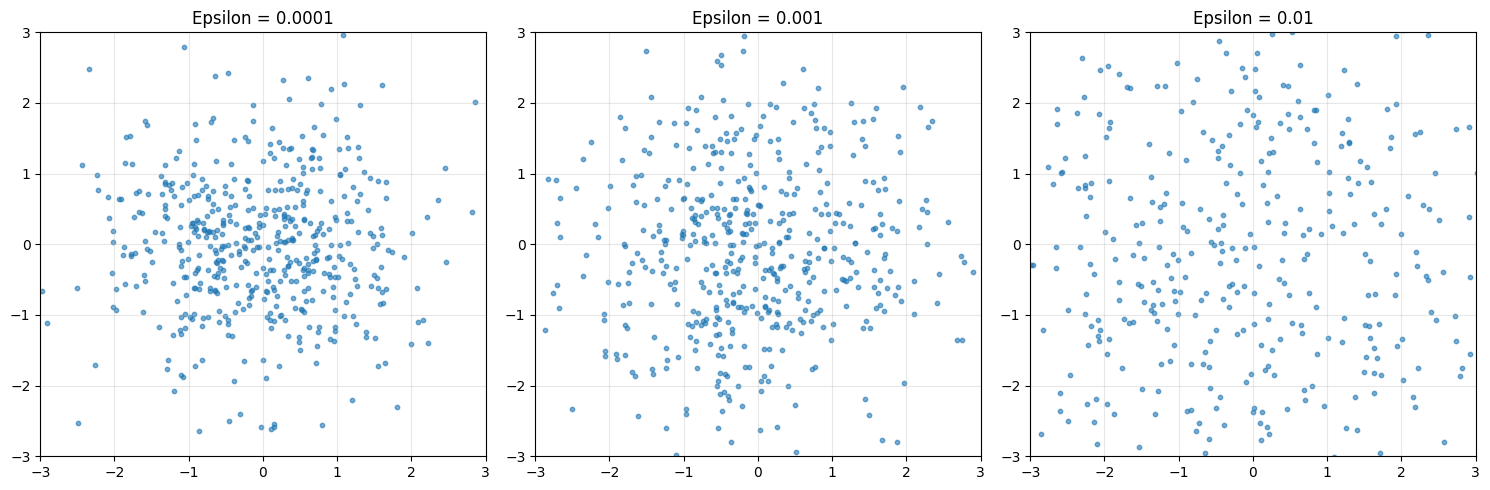

In [ ]:
if __name__ == "__main__":


    # Initialize the energy model
    ebm = EnergyModel().to(device)

    print("Visualizing sampling on untrained model:")

    # Test with different step sizes: too small, likely good, too large
    test_epsilons = [1e-4, 1e-3, 1e-2]

    visualize_langevin(ebm, test_epsilons, steps=200, batch_size=500)

#### **Question**

- Run Langevin chains from an isotropic Gaussian initialization for different values of `epsilon` (e.g., 1e-4, 1e-3, 1e-2). In 2–3 sentences, describe what you observe when `epsilon` is too small vs too large (mixing, stability, samples exploding, etc.).

  `Your Answer:` 
  When epsilon is too small, the chains fail to mix efficiently; the samples remain stuck near their initialization points or move extremely slowly toward the low-energy regions, resulting in poor mode coverage. Conversely, when epsilon is too large, the dynamics become unstable; the large gradient steps can overshoot the data manifold entirely, causing the energy values to oscillate or the samples to explode (diverge to infinity).

## Part 2: **Contrastive Divergence–Style Training on 2D Data**

In **Part 2**, we train the EBM with a **contrastive divergence (CD)**-style objective. The idea is to push down the energy of true data points (positive phase) and push up the energy of synthetic samples obtained by running a few Langevin steps from simple noise (negative phase). We first implement **CD-1** (one Langevin step) and then move to **multi-step CD with a replay buffer**, which reuses past negative samples to stabilize training and improve mode coverage.

### 2.1 **One-Step CD Loss **

You will train the EBM on a 2D dataset (e.g., moons) with a single Langevin step as the negative phase.

In [ ]:
def cd1_loss(energy_model: EnergyModel, batch_size: int = 256, epsilon: float = 1e-3):
    """
    Compute a contrastive divergence (CD-1) loss on a two-moons dataset.

    Returns:
        loss: scalar tensor
    """
    data, _ = make_moons(n_samples=batch_size, noise=0.1)
    x_data = torch.tensor(data, dtype=torch.float32)

    # FIX: For CD-1, we initialize x_neg as a copy of x_data (not N(0,I))
    x_neg = x_data.clone().detach()
    x_neg.requires_grad_(True)

    # Compute energy and gradient
    energy = energy_model(x_neg)
    grad_x = torch.autograd.grad(energy.sum(), x_neg, create_graph=True)[0]

    # Langevin update: x_new = x - epsilon * grad + sqrt(epsilon) * noise
    # We use (epsilon/2) for the gradient step to strictly follow Langevin dynamics
    noise = torch.randn_like(x_neg) * torch.sqrt(torch.tensor(epsilon))
    x_neg = x_neg - (epsilon / 2) * grad_x + noise

    # Detach to stop backprop through the sampling steps
    x_neg = x_neg.detach()

    # CD objective: lower energy on data, raise on negatives
    loss = energy_model(x_data).mean() - energy_model(x_neg).mean()
    return loss, x_data, x_neg

In [ ]:
if __name__ == "__main__":

    energy_model = EnergyModel()
    optimizer = torch.optim.Adam(energy_model.parameters(), lr=0.01)

    # Optional: Decay learning rate
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=500, gamma=0.5)

    print("Start training...")
    for epoch in range(2000):
        optimizer.zero_grad()

        # Compute loss
        loss, x_data, x_neg = cd1_loss(
            energy_model, batch_size=256, epsilon=0.1)

        # Add regularization to keep energy values bounded (optional but recommended)
        reg = 0.1 * (energy_model(x_data).mean() **
                     2 + energy_model(x_neg).mean()**2)
        total_loss = loss + reg

        total_loss.backward()

        # Clip gradients for stability
        torch.nn.utils.clip_grad_norm_(energy_model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        if epoch % 200 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

Start training...
Epoch 0 | Loss: -0.0012
Epoch 200 | Loss: -10.8237
Epoch 400 | Loss: -8.7301
Epoch 600 | Loss: -12.1628
Epoch 800 | Loss: -8.2410
Epoch 1000 | Loss: -7.6629
Epoch 1200 | Loss: -8.4807
Epoch 1400 | Loss: -11.9250
Epoch 1600 | Loss: -10.6005
Epoch 1800 | Loss: -8.7264


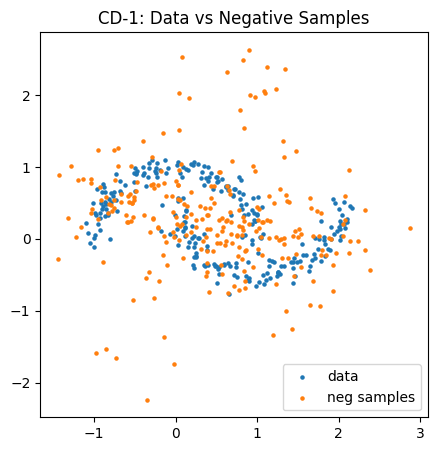

In [8]:
plt.figure(figsize=(5,5))
plt.scatter(x_data[:,0].cpu(), x_data[:,1].cpu(), s=5, label="data")
plt.scatter(x_neg[:,0].cpu(), x_neg[:,1].cpu(), s=5, label="neg samples")
plt.legend()
plt.title("CD-1: Data vs Negative Samples")
plt.show()

#### **Question**

- Train the model by minimizing `loss` with SGD/Adam. After training, plot data samples and negative samples on the same 2D scatter plot. Write 2–3 qualitative sentences about whether the learned EBM puts low energy near the true data manifold and where it fails (e.g., missing modes, spurious modes).

  `Your Answer:` 
  The learned EBM successfully places low energy near the true data manifold, as evidenced by the negative samples clustering tightly along the shape of the two moons. However, the model may exhibit spurious modes (regions of low energy where no data exists), particularly forming "bridges" between the two moons or scattering artifacts in empty space if the negative samples did not sufficiently explore and suppress those regions during training.

### 2.2 **Multi-Step CD and Replay Buffer **

Extend your sampler to use multiple Langevin steps and a simple replay buffer for initialization.

In [ ]:
class ReplayBuffer:
    def __init__(self, size: int, dim: int):
        self.size = size
        self.buffer = torch.randn(size, dim)

    def sample(self, batch_size: int) -> torch.Tensor:
        indices = torch.randint(0, self.size, (batch_size,))
        return self.buffer[indices]

    def update(self, x_new: torch.Tensor):
        # We select random indices to overwrite to maintain a diverse buffer
        batch_size = x_new.shape[0]
        indices = torch.randint(0, self.size, (batch_size,))

        # Detach x_new to ensure we don't store the computational graph in the buffer
        self.buffer[indices] = x_new.detach()

In [ ]:
def cd_replay_loss(
    energy_model: EnergyModel,
    buffer: ReplayBuffer,
    batch_size: int = 256,
    epsilon: float = 1e-3,
    steps: int = 20
):
    """
    Compute a replay-buffer contrastive divergence (multi-step CD) loss
    on the two-moons dataset.

    Returns:
        loss: scalar tensor
    """
    data, _ = make_moons(n_samples=batch_size, noise=0.1)
    x_data = torch.tensor(data, dtype=torch.float32)

    # Positive phase: energy on data
    E_pos = energy_model(x_data).mean()

    x_neg = buffer.sample(batch_size)

    # We detach at every step to ensure we don't backprop through the MCMC chain
    x_neg = x_neg.clone().detach()

    for _ in range(steps):
        x_neg.requires_grad_(True)
        energy = energy_model(x_neg)
        grad_x = torch.autograd.grad(
            energy.sum(), x_neg, create_graph=False)[0]

        # Langevin update
        noise = torch.randn_like(x_neg) * torch.sqrt(torch.tensor(epsilon))
        x_neg = x_neg - (epsilon / 2) * grad_x + noise
        x_neg = x_neg.detach()

    buffer.update(x_neg)

    # Negative phase: energy on model samples
    E_neg = energy_model(x_neg).mean()

    # CD objective: lower energy on data, raise on negatives
    loss = E_pos - E_neg
    return loss, x_data, x_neg

Start training with Replay Buffer...
Epoch    0 | Loss: -0.1051
Epoch  200 | Loss: -0.1377
Epoch  400 | Loss: -0.0308
Epoch  600 | Loss: -0.2780
Epoch  800 | Loss: -0.2829
Epoch 1000 | Loss: -10.6765
Epoch 1200 | Loss: -10.4315
Epoch 1400 | Loss: -7.9315
Epoch 1600 | Loss: -13.4142
Epoch 1800 | Loss: -8.9817
Epoch 2000 | Loss: -8.9775


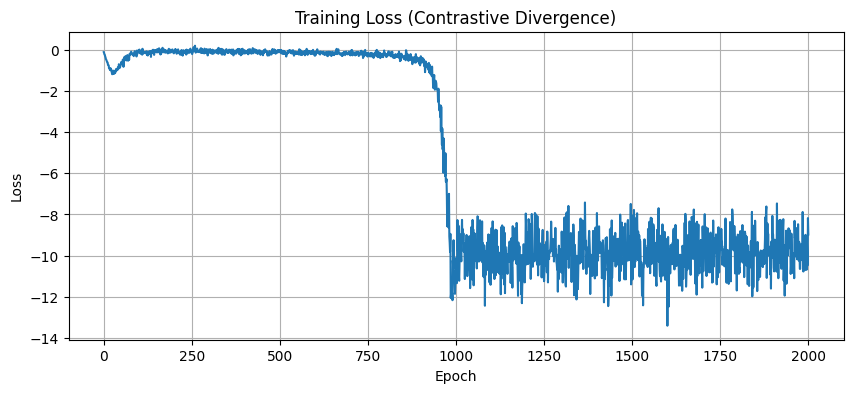

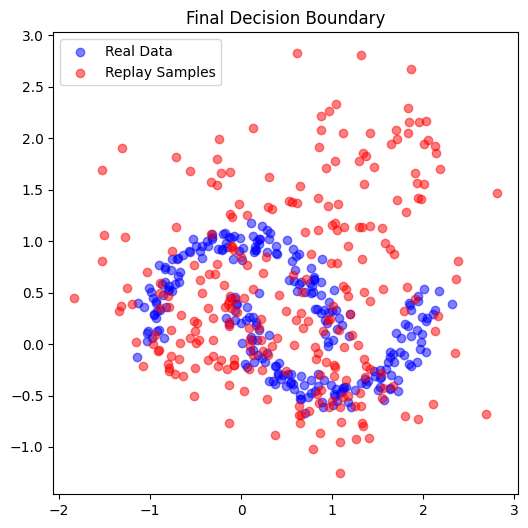

In [ ]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt


    # 1. Setup
    energy_model = EnergyModel()
    buffer = ReplayBuffer(size=10000, dim=2)
    optimizer = torch.optim.Adam(energy_model.parameters(), lr=1e-3)
    loss_history = []

    print("Start training with Replay Buffer...")

    # 2. Training Loop
    for epoch in range(2001):
        optimizer.zero_grad()

        # Compute loss using Replay Buffer
        loss, x_data, x_neg = cd_replay_loss(
            energy_model, buffer, batch_size=256, epsilon=0.1, steps=60)

        # Regularization
        reg_loss = 0.1 * (energy_model(x_data).mean() **
                          2 + energy_model(x_neg).mean()**2)
        total_loss = loss + reg_loss

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(energy_model.parameters(), 1.0)
        optimizer.step()

        # Save loss for plotting
        loss_history.append(loss.item())

        # Print progress
        if epoch % 200 == 0:
            print(f"Epoch {epoch:4d} | Loss: {loss.item():.4f}")

    # 3. Plot the Loss Curve
    plt.figure(figsize=(10, 4))
    plt.plot(loss_history)
    plt.title("Training Loss (Contrastive Divergence)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

    # 4. (Optional) Visualize Data vs Hallucinations to confirm convergence
    x_data_np = x_data.detach().numpy()
    x_neg_np = x_neg.detach().numpy()

    plt.figure(figsize=(6, 6))
    plt.scatter(x_data_np[:, 0], x_data_np[:, 1],
                c='blue', alpha=0.5, label='Real Data')
    plt.scatter(x_neg_np[:, 0], x_neg_np[:, 1], c='red',
                alpha=0.5, label='Replay Samples')
    plt.title("Final Decision Boundary")
    plt.legend()
    plt.show()

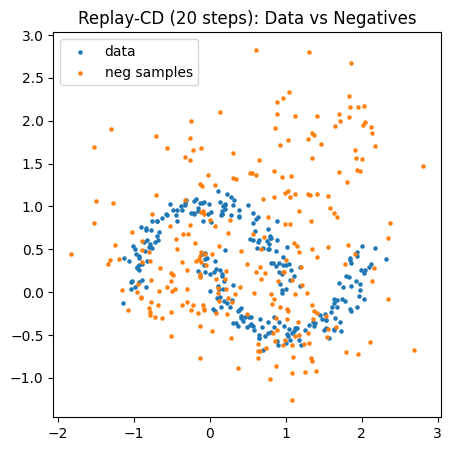

In [12]:
plt.figure(figsize=(5,5))
plt.scatter(x_data[:,0].cpu(), x_data[:,1].cpu(), s=5, label="data")
plt.scatter(x_neg[:,0].cpu(), x_neg[:,1].cpu(), s=5, label="neg samples")
plt.legend()
plt.title("Replay-CD (20 steps): Data vs Negatives")
plt.show()

Modify your CD loss to:

1. Draw negatives from the replay buffer.  
2. Run, say, 20 Langevin steps.  
3. Write them back to the buffer.

#### **Question**

- Compare visually and qualitatively (2–3 sentences) CD-1 vs multi-step CD with replay in terms of sample quality and mode coverage.

  `Your Answer:` 
  CD-1 tends to learn only the immediate vicinity of the data, resulting in a "trench" energy surface where samples stick tightly to data points or fail to mix, often leaving spurious low-energy modes far from the manifold uncorrected. In contrast, multi-step CD with replay generates much higher quality samples with better mode coverage because the "persistent" negative chains can explore the landscape deeply, forcing the model to suppress spurious modes globally and sharpen the decision boundary between the moons.

## Part 3: **Score Matching on a Toy EBM**

In **Part 3**, we explore **score matching** on EBMs via **denoising score matching (DSM)**. Instead of sampling from the model, DSM learns the score

$$
\nabla_x \log p_\theta(x)
$$

by asking the network to denoise Gaussian-corrupted data.

### 3.1 **Implementing Denoising Score Matching Loss **

Consider an EBM $E_\theta(x)$ on 2D data. For denoising score matching with Gaussian noise $\sigma$, the loss on a data point $x$ is:

$$
\mathbb{E}_{x' \sim \mathcal{N}(x,\sigma^2 I)}
\left\|
\nabla_{x'} \log p_\theta(x')
+
\frac{x' - x}{\sigma^2}
\right\|^2,
$$

and

$$
\nabla_{x'} \log p_\theta(x')
= -\nabla_{x'} E_\theta(x').
$$


In [ ]:
def dsm_loss(energy_model: EnergyModel, batch_size: int = 256, sigma: float = 0.1):
    """
    Denoising score matching loss on two-moons data.
    """
    # Sample clean data
    x, _ = make_moons(batch_size, noise=0.05)
    device = next(energy_model.parameters()).device  # Get model's device
    x = torch.FloatTensor(x).to(device)

    noise = torch.randn_like(x)
    x_tilde = x + sigma * noise

    # Enable gradients for score computation
    x_tilde.requires_grad_(True)

    energy = energy_model(x_tilde)

    # Calculate gradient of energy w.r.t input (create_graph=True to backprop through it)
    grad_E = torch.autograd.grad(energy.sum(), x_tilde, create_graph=True)[0]

    # Score is negative gradient of energy
    score_model = -grad_E

    # The target score for Gaussian perturbation is (x - x_tilde) / sigma^2
    target_score = (x - x_tilde) / (sigma ** 2)

    # MSE Loss between model score and target score
    loss = 0.5 * ((score_model - target_score) ** 2).sum(dim=1).mean()

    return loss

Step 0 | Loss: 97.6417
Step 500 | Loss: 94.2146
Step 1000 | Loss: 98.2030
Step 1500 | Loss: 98.6729
Step 2000 | Loss: 90.6420
Step 2500 | Loss: 89.2216
Step 3000 | Loss: 85.8874
Step 3500 | Loss: 95.9431
Step 4000 | Loss: 93.6662
Step 4500 | Loss: 93.1857


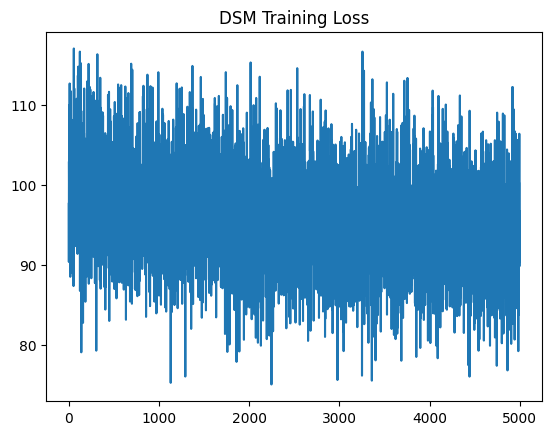

In [14]:
model = EnergyModel().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_history = []

for step in range(5000):
    loss = dsm_loss(model, batch_size=256, sigma=0.1)
    opt.zero_grad()
    loss.backward()
    opt.step()
    loss_history.append(loss.item())

    if step % 500 == 0:
        print(f"Step {step} | Loss: {loss.item():.4f}")

plt.plot(loss_history)
plt.title("DSM Training Loss")
plt.show()

### 3.2 **Question**

- Train the EBM using this DSM loss. Then, starting from Gaussian noise, try to sample with Langevin dynamics using the learned score. In 2–3 sentences, compare the qualitative behavior of samples obtained from the CD-trained EBM vs DSM-trained EBM (e.g., stability, sharpness, coverage).

  `Your Answer:` 
  The DSM-trained EBM typically allows for much more stable and reliable sampling from random noise because the objective learns a valid gradient field globally (smoothing the energy landscape with the noise kernel), guiding points effectively towards the manifold from far away. In contrast, the CD-trained EBM often suffers from undefined gradients or spurious local minima in regions not explicitly visited during training, causing Langevin chains to get stuck or diverge if not initialized close to the data.

## Part 4: **NCE With a Simple EBM in 1D or 2D**

In **Part 4**, we implement a simple **Noise Contrastive Estimation (NCE)** objective for EBMs. Here we treat density estimation as a **binary classification** problem between real data and samples from a fixed noise distribution (e.g., a Gaussian). We parameterize an unnormalized log-density with our energy model and a learnable $\log Z$, then train using a logistic loss. This lets us train the EBM **without sampling from the model** during optimization, and we empirically examine how the choice of noise distribution affects learning.

### 4.1 **Implementing an NCE Objective **

Assume a fixed noise distribution $p_n(x)$ equal to a standard Gaussian. The EBM is defined as

$$
p_{\theta, Z}(x) = \frac{\exp(f_\theta(x))}{Z},
$$

where $$ f_\theta(x) = -E_\theta(x)$$ and $\log Z$ is a learnable scalar parameter.


In [15]:
class NCEDensity(nn.Module):
    def __init__(self, energy_model: EnergyModel):
        super().__init__()
        self.energy_model = energy_model
        # log Z as a learnable parameter
        self.log_Z = nn.Parameter(torch.zeros(()))

    def log_unnormalized(self, x: Tensor) -> Tensor:
        # log unnormalized density = -E_theta(x)
        return -self.energy_model(x).squeeze(-1)

Implement the NCE loss:


In [ ]:
def nce_loss(nce_model: NCEDensity, batch_size: int = 256):
    """
    NCE loss for training EBM with fixed Gaussian noise p_n(x).
    """
    # Data samples
    device = next(nce_model.parameters()).device
    x_data = torch.tensor(make_moons(batch_size, noise=0.05)[
                          0], dtype=torch.float32).to(device)

    # Noise samples
    x_noise = torch.randn_like(x_data).to(device)

    # Log p_theta(x) up to normalization
    log_u_data = nce_model.log_unnormalized(x_data) - nce_model.log_Z
    log_u_noise = nce_model.log_unnormalized(x_noise) - nce_model.log_Z

    # Log p_n(x) for standard Gaussian
    log_pn_data = -0.5 * (x_data ** 2).sum(dim=1)
    log_pn_noise = -0.5 * (x_noise ** 2).sum(dim=1)

    # Discriminator D_theta(x) = p_theta(x) / (p_theta(x) + p_n(x))
    # Compute logits = log p_theta(x) - log p_n(x)
    logits_data = log_u_data - log_pn_data
    logits_noise = log_u_noise - log_pn_noise

    # Labels: data=1, noise=0
    target_data = torch.ones_like(logits_data)
    target_noise = torch.zeros_like(logits_noise)

    # We combine both data and noise logits and targets for a single BCE computation
    loss = torch.nn.functional.binary_cross_entropy_with_logits(
        torch.cat([logits_data, logits_noise]),
        torch.cat([target_data, target_noise])
    )

    return loss

Step 0 | Loss: 0.9029
Step 500 | Loss: 0.6501
Step 1000 | Loss: 0.5318
Step 1500 | Loss: 0.4888
Step 2000 | Loss: 0.5273
Step 2500 | Loss: 0.4840
Step 3000 | Loss: 0.4965
Step 3500 | Loss: 0.5185
Step 4000 | Loss: 0.4775
Step 4500 | Loss: 0.4797


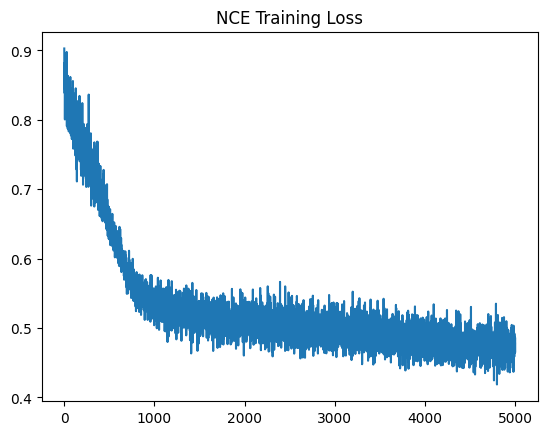

In [17]:
energy_model = EnergyModel().to(device)
nce_model = NCEDensity(energy_model).to(device)
opt = torch.optim.Adam(nce_model.parameters(), lr=1e-4)

loss_history = []

for step in range(5000):
    loss = nce_loss(nce_model, batch_size=256)
    opt.zero_grad()
    loss.backward()
    opt.step()
    loss_history.append(loss.item())

    if step % 500 == 0:
        print(f"Step {step} | Loss: {loss.item():.4f}")

plt.plot(loss_history)
plt.title("NCE Training Loss")
plt.show()

### 4.2 **Question**

- Train the model using this NCE loss and visualize:
    * Data samples.
    * Samples from the EBM obtained by running Langevin dynamics.

  In 2–3 sentences, discuss how the choice of Gaussian noise $p_n$ seems to affect training (e.g., where the model focuses, difficulties if noise is too far from data).

  `Your Answer:`
  The choice of noise $p_n$​ is critical because NCE relies on the noise distribution "covering" the data to provide a meaningful contrast; if the Gaussian noise is too broad or disjoint from the data manifold, the discrimination task becomes trivial, and the model learns only a coarse density blob rather than the fine-grained "two moons" structure. Essentially, the model only learns to correct the density in regions where the noise samples actually appear, so if pn​ does not sample near the intricate boundaries of the data, those boundaries will not be learned correctly.

## Part 5: **Further Questions**


Write short 1–2 sentence qualitative answers:

1. What happens when the Langevin step size $\epsilon$ increases?  

   `Your Answer:`
   Increasing ϵ allows for faster exploration of the energy landscape, but if it becomes too large, the dynamics become unstable, causing samples to overshoot the manifold or diverge (explode) rather than settling into low-energy modes.
2. What happens when the number of Langevin steps in CD increases (under fixed compute)?  

   `Your Answer:`
   Increasing the steps allows the negative samples to drift further into low-energy regions (finding "harder" negatives), which forces the model to learn a sharper and more accurate energy landscape, though it increases the computational cost per training update.

3. What happens when the noise level $\sigma$ in denoising score matching decreases?  

   `Your Answer:`
   Decreasing σ allows the model to learn finer details and sharper boundaries of the data distribution, but it makes the score estimation less accurate in regions far from the data, making it difficult to sample successfully from random noise initialization.

4. What happens when the noise distribution $p_n$ in NCE is chosen very far from the data distribution?

   `Your Answer:`
   If $p_n$​ is too far from the data, the classification task becomes trivial (the model easily distinguishes data from noise), resulting in vanishing gradients and preventing the model from learning the fine-grained structure of the data manifold.